<a href="https://colab.research.google.com/github/mtodisco10/fastaiProjects/blob/master/first_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

In [12]:
def download_pics(category_lst):
  path = Path('architecture/buildings')
  for f in category_lst:
    print(f'Downloading {f} images')
    folder = f
    file = f + '.csv'
    dest = path/folder
    dest.mkdir(parents=True, exist_ok=True)
    download_images(file, dest, max_pics=200)

category_lst = ['classical','gothic','modern','victorian']
download_pics(category_lst)

In [14]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

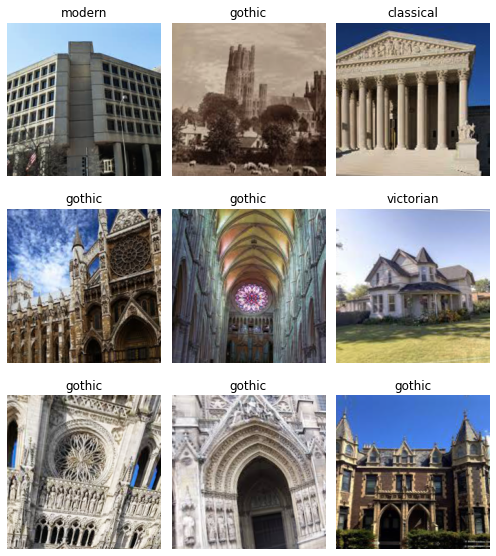

In [15]:
data.show_batch(rows=3, figsize=(7,8))

In [16]:
classes = ['classical', 'gothic', 'modern', 'victorian']
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

classical


gothic


modern


victorian


# Train the Model

In [26]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [27]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.339417,1.502874,0.602410,00:04
1,1.512183,0.741244,0.228916,00:04
2,1.098136,0.747716,0.228916,00:04
3,0.877351,0.722981,0.204819,00:04


In [28]:
learn.save('stage-1')

In [29]:
learn.unfreeze()

In [30]:
learn.fit_one_cycle(6, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.441094,0.740994,0.228916,00:04
1,0.329653,0.841772,0.289157,00:04
2,0.300665,0.861227,0.265060,00:04
3,0.259101,0.943490,0.277108,00:04
4,0.217691,0.896095,0.277108,00:04
5,0.192901,0.868442,0.253012,00:04


In [31]:
interp = ClassificationInterpretation.from_learner(learn)

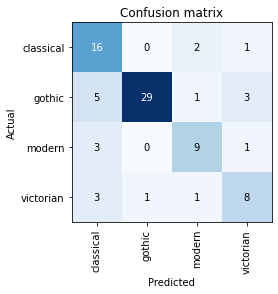

In [32]:
interp.plot_confusion_matrix()

In [33]:
print('This isn\'t too shabby for a first try')

This isn't too shabby for a first try


In [36]:
learn.export()

In [37]:
defaults.device = torch.device('cpu')

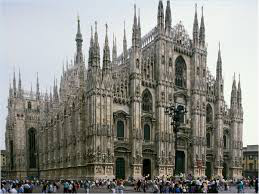

In [39]:
img = open_image(path/'gothic'/'00000000.jpg')
img

In [41]:
learn = load_learner(path)

In [45]:
pred_class, pred_idx, outputs = learn.predict(img)
pred_class.obj

'gothic'